In [1]:
import gymnasium as gymnasium
import numpy as np
import pandas as pd
import joblib
import random
from typing import Optional, Tuple, List

In [ ]:
class TradingEnv(gymnasium.Env):
    
    def __init__(self, data: pd.DataFrame, initial_cash: float = 10_000, window_size: int = 14, scaler_path: str = "../Transform_data/scaler.pkl", default_seed: int = 42):
        super().__init__()

        if 'return_1h' not in data.columns:
            raise ValueError("Das DataFrame muss die Spalte 'return_1h' enthalten!")
        if window_size <= 0 or window_size > len(data):
            raise ValueError("window_size muss größer als 0 und kleiner oder gleich der Länge der Daten sein!")


        # 1️⃣ Marktdaten speichern & Index setzen
        self.data = data.reset_index(drop=True)  # Index zurücksetzen (sicherstellen, dass 0-basiert)
        self.current_step = 0

        # 5️⃣ Moving Window: Anzahl vergangener Zeitschritte, die beobachtet werden sollen
        self.window_size = window_size

        # 2️⃣ Portfolio-Variablen initialisieren
        self.initial_cash = initial_cash
        self.cash = initial_cash
        self.invested_value = 0.0
        self.portfolio_value = initial_cash

        # Listen für die Historie anlegen (Anfangsdaten um Fehler zu vermeiden)
        self.cash_history = [initial_cash]
        self.invested_value_history = [0.0]
        self.portfolio_value_history = [initial_cash]


        # 3️⃣ Gymnasium-Umgebungseigenschaften
        #    a) Diskreter Aktionsraum (9 mögliche Aktionen: Halten, Kaufen/Verkaufen in 25%-Schritten)
        self.action_space = gymnasium.spaces.Discrete(9)
        self.action_space.seed(default_seed)  # Seed für den Aktionsraum setzen
        #    b) Beobachtungsraum: Ein Zeitfenster (window_size) mit allen Marktdaten-Spalten + 3 Portfolio-Features
        obs_shape = (self.window_size, len(self.data.columns) + 3)
        
        self.observation_space = gymnasium.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=obs_shape,
            dtype=np.float32
        )

        # Setze den Default-Seed beim Initialisieren
        self.seed(default_seed)
        
         # Lade den Scaler einmalig und speichere ihn als Attribut        
        try:
            self.scaler = joblib.load(scaler_path)
        except Exception as e:
            raise RuntimeError(f"Fehler beim Laden des Scalers aus {scaler_path}: {e}")

In [3]:
def seed(self, seed: Optional[int] = None) -> List[int]:
    if seed is None:
        seed = 42  # Default-Wert
    # Neuer lokaler RNG mit der neuen API
    self.np_random = np.random.default_rng(seed)
    print(f"Seed in the environment: {seed}")
    # Setze den Seed für das Python-eigene Zufallsmodul
    random.seed(seed)
    # Setze den globalen Seed für np.random (legacy API), falls externe Bibliotheken diesen verwenden
    np.random.seed(seed)
    return [seed]

TradingEnv.seed = seed

In [4]:
def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, dict]:
    """
    Setzt das Environment in den Anfangszustand zurück und gibt die initiale Beobachtung zurück.
    
    :param seed: Optionaler Seed zur Reproduzierbarkeit.
    :param options: Zusätzliche Optionen (zurzeit ungenutzt).
    :return: Ein Tuple (observation, info), wobei 'observation' der erste Beobachtungsvektor ist
             und 'info' ein leeres Dictionary darstellt.
    """
    # Optional: Seed setzen, falls übergeben (vorausgesetzt, du hast eine seed()-Methode implementiert)
    if seed is not None:
            self.seed(seed)
    else:
        # Optional: Wenn kein Seed übergeben wird, kann auch ein Default-Seed gesetzt werden
        self.seed()
    
    # Reset des Zeitschritts
    self.current_step = 0
    
    # Setze das Portfolio auf den Ausgangszustand zurück
    # Wichtig: Speichere den initialen Cash-Wert in __init__ als self.initial_cash!
    self.cash = self.initial_cash
    self.invested_value = 0.0
    self.portfolio_value = self.initial_cash

    # Historien mit den Startwerten initialisieren
    self.cash_history = [self.cash]
    self.invested_value_history = [self.invested_value]
    self.portfolio_value_history = [self.portfolio_value]
    
    # Erzeuge die erste Beobachtung (z.B. das erste Moving-Window)
    observation = self._next_observation()
    
    return observation, {}

TradingEnv.reset = reset

In [5]:
def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, dict]:
    # 0️⃣ Aktion validieren
    if not self.action_space.contains(action):
        raise ValueError(f"Ungültige Aktion: {action}")

    # 1️⃣ Aktion ausführen
    self._execute_trade(action)

    # 2️⃣ Zum nächsten Zeitschritt übergehen
    self.current_step += 1

    # 3️⃣ Prüfen, ob wir am Ende der Daten angekommen sind
    if self.current_step >= len(self.data):
            obs = self._next_observation()  # Meist ein Dummy-Obs oder das letzte gültige
            reward = 0.0
            done = True
            truncated = False
            return obs, reward, done, truncated, {}

    # 4️⃣ Denormalisierten Return berechnen und auf investiertes Kapital anwenden
    standardized_return = self.data.loc[self.current_step, 'return_1h']
    real_return = self._denormalize_return(standardized_return)
    self.invested_value *= (1.0 + real_return)
    
    # 4.1 Aktualisiere den Portfolio-Wert (Cash + Investitionen)
    self.portfolio_value = self.cash + self.invested_value

    # 5️⃣ Historien aktualisieren (nur die für die Beobachtung relevanten Werte werden später gesliced)
    self.cash_history.append(self.cash)
    self.invested_value_history.append(self.invested_value)
    self.portfolio_value_history.append(self.portfolio_value)

    # 6️⃣ Reward berechnen
    reward = self._calculate_reward()

    # 7️⃣ Neue Beobachtung (Moving Window) generieren
    obs = self._next_observation()

    # 8️⃣ Prüfen, ob die Episode beendet ist (z.B. kein Geld mehr oder keine weiteren Daten)
    done = self._check_done()

    truncated = False  # Kann später angepasst werden, falls weitere Abbruchgründe definiert werden
    return obs, reward, done, truncated, {}

TradingEnv.step = step

In [6]:
def _next_observation(self) -> np.ndarray:
    # Berechne Start- und End-Index für das Beobachtungsfenster
    end_idx = self.current_step + 1
    start_idx = max(0, end_idx - self.window_size)

    # 1️⃣ Marktdaten abrufen und in Float32 konvertieren
    data_slice = self.data.iloc[start_idx:end_idx].values
    # Bestimme, wie viele Zeilen fehlen, um die window_size zu erreichen
    pad_rows = self.window_size - data_slice.shape[0]
    # Pad das Array oben (also vor den vorhandenen Daten)
    market_data_window = np.pad(data_slice, ((pad_rows, 0), (0, 0)), mode='constant', constant_values=0)

    # Hilfsfunktion zum Padding der Portfolio-Daten
    def pad_feature(feature_history: list) -> np.ndarray:
        feature_slice = np.array(feature_history[start_idx:end_idx], dtype=np.float32)
        pad_length = self.window_size - feature_slice.shape[0]
        # Pad das Array, damit es immer window_size Zeilen hat
        padded_feature = np.pad(feature_slice, (pad_length, 0), mode='constant', constant_values=0)
        return padded_feature.reshape(-1, 1)

    # 2️⃣ Portfolio-Daten abrufen und paddern
    cash_window = pad_feature(self.cash_history)
    invested_window = pad_feature(self.invested_value_history)
    portfolio_window = pad_feature(self.portfolio_value_history)

    # 3️⃣ Zusammenführen der Marktdaten und Portfolio-Daten
    observation = np.hstack([
        market_data_window,
        cash_window,
        invested_window,
        portfolio_window
    ])

    return observation

TradingEnv._next_observation = _next_observation

In [7]:
def _check_done(self) -> bool:

    # 1️⃣ Episode beenden, wenn keine weiteren Marktdaten vorhanden sind
    if self.current_step >= len(self.data) - 1:
        return True

    # 2️⃣ Episode beenden, wenn das gesamte Kapital (Cash & Investitionen) praktisch aufgebraucht ist
    # np.isclose verwendet eine Toleranz, um Rundungsfehler zu vermeiden
    if np.isclose(self.cash, 0.0) and np.isclose(self.invested_value, 0.0):
        return True

    return False

TradingEnv._check_done = _check_done

In [8]:
def _calculate_reward(self) -> float:
    
    if len(self.portfolio_value_history) < 2:
        return 0  # Kein Risiko, keine Belohnung in den ersten Schritten

    # 1️⃣ Direkte Belohnung: Hat sich das Portfolio nach der Aktion verbessert?
    previous_value = self.portfolio_value_history[-2] if len(self.portfolio_value_history) > 1 else self.portfolio_value
    current_value = self.portfolio_value
    immediate_reward = (current_value - previous_value) / previous_value  # Relative Veränderung

    # **Normalisierung:** Typische Werte ±5 % pro Schritt
    immediate_reward = np.clip(immediate_reward, -0.05, 0.05) / 0.05  

    # 2️⃣ Benchmark: Wie gut wäre "Buy-and-Hold" gewesen?
    if self.invested_value > 0:
        standardized_return = self.data.loc[self.current_step, 'return_1h']
        real_return = self._denormalize_return(standardized_return)
        buy_and_hold_value = self.invested_value * (1.0 + real_return) + self.cash
    else:
        buy_and_hold_value = self.portfolio_value  

    strategy_improvement = (current_value - buy_and_hold_value) / buy_and_hold_value

    # **Normalisierung:** Typische Werte ±5 % pro Schritt
    strategy_improvement = np.clip(strategy_improvement, -0.05, 0.05) / 0.05  

    # 3️⃣ Finale Berechnung des Rewards mit Gewichtung (Sharpe Ratio entfernt!)
    reward = (0.2 * immediate_reward) + (0.8 * strategy_improvement)

    return reward

TradingEnv._calculate_reward = _calculate_reward

In [9]:
def _execute_trade(self, action: int) -> None:
    # Mapping: Aktion -> zugehörige Methode inkl. Parameter
    trade_actions = {
        # Kaufaktionen: 1-4
        1: lambda: self._buy(0.25),
        2: lambda: self._buy(0.50),
        3: lambda: self._buy(0.75),
        4: lambda: self._buy(1.00),
        # Verkaufsaktionen: 5-8
        5: lambda: self._sell(0.25),
        6: lambda: self._sell(0.50),
        7: lambda: self._sell(0.75),
        8: lambda: self._sell(1.00)
    }

    trade_actions.get(action, lambda: None)()  # Falls `action == 0`, passiert nichts

        
TradingEnv._execute_trade = _execute_trade

In [10]:
def _buy(self, percentage: float) -> None:
    # Validierung des Prozentwerts
    if not 0 < percentage <= 1:
        raise ValueError("Der Kaufprozentsatz muss zwischen 0 (exklusiv) und 1 (inklusiv) liegen.")
    
    # Prüfen, ob genug Cash vorhanden ist
    if self.cash <= 0:
        return  # Kein Kauf möglich, wenn kein Cash verfügbar ist

    # Berechne den Kaufbetrag (hier könnte man auch Transaktionskosten etc. einbauen)
    buy_amount = self.cash * percentage

    # Update des Portfolios: Cash reduzieren, investiertes Kapital erhöhen
    self.cash -= buy_amount
    self.invested_value += buy_amount
    self.portfolio_value = self.cash + self.invested_value

TradingEnv._buy = _buy

In [11]:
def _sell(self, percentage: float) -> None:
    # Validierung des Prozentwerts
    if not 0 < percentage <= 1:
        raise ValueError("Der Verkaufsprozentsatz muss zwischen 0 (exklusiv) und 1 (inklusiv) liegen.")

    # Prüfen, ob investiertes Kapital vorhanden ist
    if self.invested_value <= 0:
        return  # Nichts zu verkaufen

    # Berechne den Verkaufsbetrag
    sell_amount = self.invested_value * percentage

    # Update des Portfolios: Investiertes Kapital reduzieren, Cash erhöhen
    self.invested_value -= sell_amount
    self.cash += sell_amount
    self.portfolio_value = self.cash + self.invested_value

TradingEnv._sell = _sell

In [12]:
def _denormalize_return(self, normalized_return: float, feature_name: str = "return_1h") -> float:

    # Feature-Liste aus dem Scaler abrufen
    if hasattr(self.scaler, "feature_names_in_"):
        feature_cols = list(self.scaler.feature_names_in_)
    else:
        raise ValueError("Der Scaler enthält keine gespeicherten Feature-Namen!")

    if feature_name not in feature_cols:
        raise ValueError(f"Feature '{feature_name}' wurde im Scaler nicht gefunden!")

    feature_idx = feature_cols.index(feature_name)
    mean = self.scaler.mean_[feature_idx]
    std = self.scaler.scale_[feature_idx]

    real_return = normalized_return * std + mean
    return real_return

TradingEnv._denormalize_return = _denormalize_return

In [13]:
def calculate_buy_and_hold(self) -> np.ndarray:
    """
    Berechnet den Buy‑and‑Hold-Portfolioverlauf nur über die tatsächlich
    durchlaufenen Zeitschritte der aktuellen Episode.
    
    :return: Ein NumPy-Array mit den Portfolio-Werten, basierend auf den
             denormalisierten Returns über die durchlaufenen Schritte.
    """
    # Bestimme die Anzahl der Schritte, die in der Episode durchlaufen wurden
    steps = self.current_step + 1  # +1, weil current_step 0-basiert ist
    portfolio_value = self.initial_cash
    portfolio_values = [portfolio_value]

    # Berechne den Buy‑and‑Hold-Verlauf nur über die durchlaufenen Schritte
    for idx in range(1, steps):
        normalized_return = self.data.loc[idx, 'return_1h']
        real_return = self._denormalize_return(normalized_return)
        portfolio_value *= (1.0 + real_return)
        portfolio_values.append(portfolio_value)
    
    return np.array(portfolio_values)

TradingEnv.calculate_buy_and_hold = calculate_buy_and_hold

In [14]:
def render(self, mode: str = "human") -> Optional[str]:
    """
    Rendert den aktuellen Zustand des Environments.
    
    Unterstützte Modi:
    - "human": Zeigt zwei Grafiken:
         1. Den Vergleich: Trading Portfolio vs. Buy & Hold
         2. Den prozentualen Anteil des investierten Kapitals am Gesamtportfolio
    - "ansi": Gibt eine textuelle Zusammenfassung des aktuellen Zustands zurück.
    
    :param mode: Der Darstellungsmodus (default: "human").
    :return: Im "ansi"-Modus wird ein String zurückgegeben, ansonsten None.
    """
    if mode == "ansi":
        info = (
            f"Step: {self.current_step}\n"
            f"Cash: {self.cash:.2f}\n"
            f"Invested Value: {self.invested_value:.2f}\n"
            f"Portfolio Value: {self.portfolio_value:.2f}\n"
        )
        return info

    elif mode == "human":
        import matplotlib.pyplot as plt
        import numpy as np

        # Berechne den Buy & Hold Verlauf über die durchlaufenen Schritte
        buy_and_hold_values = self.calculate_buy_and_hold()
        trading_values = np.array(self.portfolio_value_history)
        timesteps = np.arange(len(trading_values))
        
        # Berechne den prozentualen Anteil des investierten Kapitals
        # Vermeide Division durch 0, indem nur dort dividiert wird, wo portfolio_value > 0
        portfolio_values = np.array(self.portfolio_value_history)
        invested_values = np.array(self.invested_value_history)
        invested_percentage = np.where(
            portfolio_values > 0,
            (invested_values / portfolio_values) * 100,
            0
        )

        # Erstelle ein Figure mit zwei vertikal angeordneten Subplots
        fig, axs = plt.subplots(2, 1, figsize=(12, 10))

        # Erster Subplot: Vergleich Trading vs. Buy & Hold
        axs[0].plot(timesteps, trading_values, label="Trading Portfolio Value", color='blue', linewidth=2)
        axs[0].plot(timesteps, buy_and_hold_values, label="Buy & Hold Portfolio Value", color='orange', linewidth=2)
        axs[0].set_xlabel("Timestep")
        axs[0].set_ylabel("Portfolio Value")
        axs[0].set_title("Portfolio Comparison: Trading vs. Buy & Hold")
        axs[0].legend()
        axs[0].grid(True)

        # Zweiter Subplot: Prozentual investiertes Kapital
        axs[1].plot(timesteps, invested_percentage, label="Invested Percentage", color='green', linestyle='--', linewidth=2)
        axs[1].set_xlabel("Timestep")
        axs[1].set_ylabel("Invested % of Portfolio")
        axs[1].set_title("Percentage of Portfolio Invested Over Time")
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    else:
        raise NotImplementedError(f"Render mode '{mode}' wird nicht unterstützt.")

# Zuweisung der neuen render-Methode an die Environment-Klasse:
TradingEnv.render = render

# Testing and Debugging

Seed in the environment: 42
Seed in the environment: 42


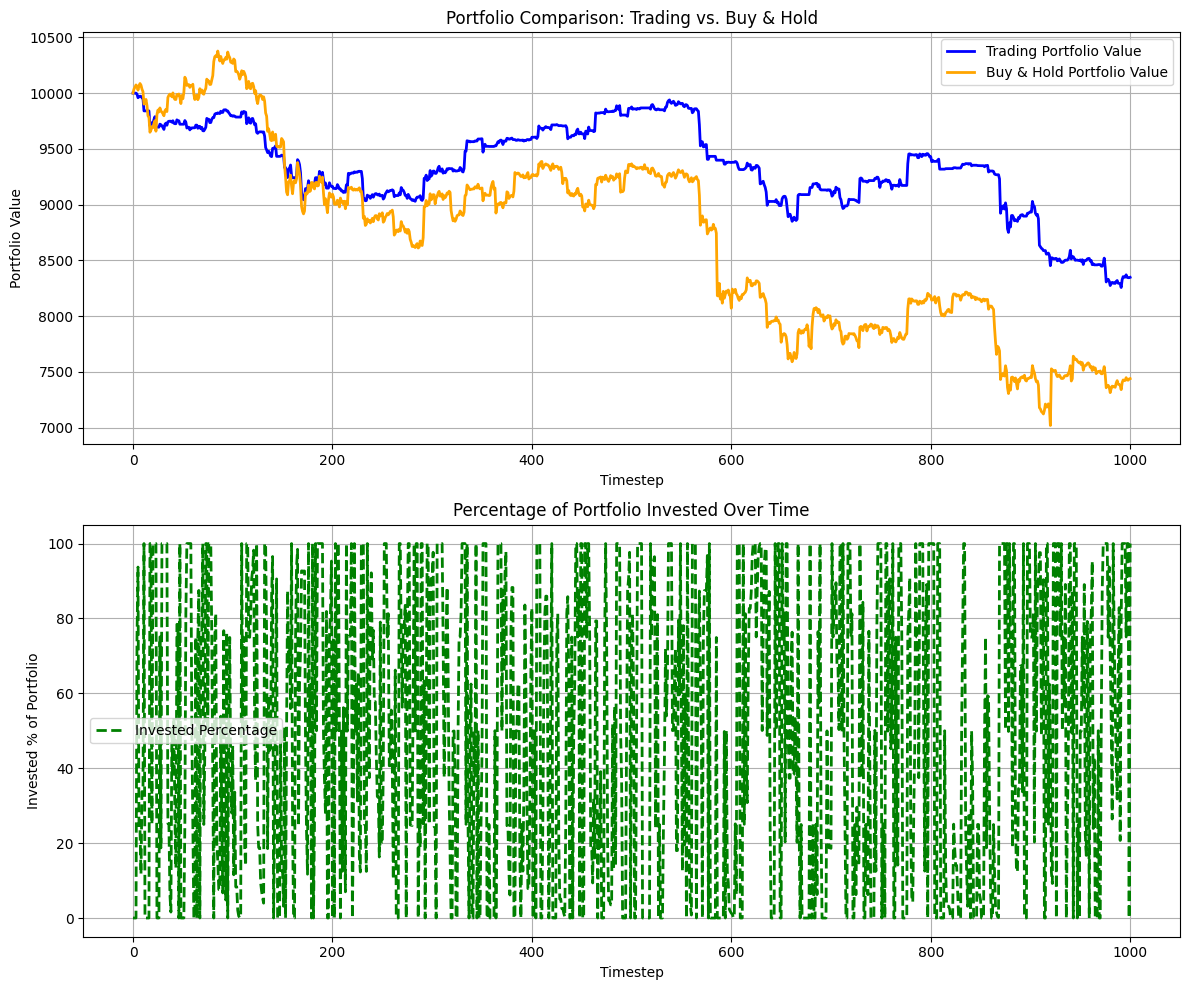

In [ ]:
SEED = 42

def test():
    # ---------------------------
    # CSV-Daten einlesen
    # ---------------------------
    # Ersetze 'pfad_zur_datei.csv' mit dem tatsächlichen Pfad zu deiner CSV-Datei.
    csv_data = pd.read_csv("../Transform_data/stand_data/2023-2018_stand_data.csv")

    # ---------------------------
    # Environment-Instanz erzeugen
    # ---------------------------
    # Stelle sicher, dass der Pfad zum Scaler stimmt. Hier wird ein Dummy-Pfad genutzt.
    env = TradingEnv(
        data=csv_data,
        initial_cash=10_000,
        window_size=14,
        scaler_path="../Transform_data/scaler.pkl",  # Muss existieren oder einen Dummy-Scaler liefern
        default_seed=SEED
    )

    # ---------------------------
    # Environment zurücksetzen (mit Seed) und 100 zufällige Aktionen durchführen
    # ---------------------------
    observation, info = env.reset(seed=SEED)

    for _ in range(1000):
        action = env.action_space.sample()  # Zufällige Aktion auswählen
        observation, reward, done, truncated, info = env.step(action)
        if done:
            break

    # ---------------------------
    # Portfolio-Entwicklung grafisch anzeigen
    # ---------------------------
    env.render(mode="human")

#test()

In [16]:
print("Notebook ausgeführt")

Notebook ausgeführt
